In [74]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_STATE = 42

df = pd.read_csv("../../datasets/famcs_students.csv")

df.head()

,cource,group,stream,sex,age,ss,interest,os,weekend_study,bad_sleep,...,social,sport,miss,study_form,foot_size,eye_color,score,retake,hostel,literature
0,4,11,Прикладная информатика,М,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Редко, легкая физкультура",3.0,Бюджет,48.0,Карие,9.2,0,"Нет, я из Минска",Да
1,4,11,Прикладная информатика,Ж,20.0,Нет,Программирование,MacOS,Нет,Нет,...,Экстраверт,"Да, я спортсмен",5.0,Бюджет,39.0,Зеленые,8.8,0,"Нет, я из Минска",Да
2,4,11,Прикладная информатика,Ж,19.0,Нет,Программирование,MacOS,Да,Нет,...,Экстраверт,Вообще нет,10.0,Бюджет,41.0,Карие,8.8,0,"Нет, я из Минска",Да
3,4,11,Прикладная информатика,Ж,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Да, я спортсмен",3.0,Бюджет,36.0,Карие,8.8,0,"Нет, я из Минска",Да
4,4,11,Прикладная информатика,М,20.0,Нет,Математика,Windows,Да,Нет,...,Интроверт,Вообще нет,1.0,Бюджет,46.0,Зеленые,9.0,0,"Нет, я из Минска",Да


In [76]:
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep',
               'glasses', 'anime', 'study_form', 'literature']

mapping = {
    'Да': 1,
    'Нет': 0,
    'М': 0,
    'Ж': 1,
    'Бюджет': 0,
    'Платная': 1,
    'Математика': 0,
    'Программирование': 1
}

df_enc = df.copy()

for col in binary_cols + ['sex']:
    if col in df_enc.columns:
        df_enc[col] = df_enc[col].map(mapping)

N = 8
target_col = binary_cols[N % 8]
print("Целевая переменная:", target_col)

feature_cols = [
    'sex', 'age', 'interest', 'weekend_study', 'bad_sleep',
    'glasses', 'anime', 'study_form', 'literature', 'score', 'miss'
]

X = df_enc[feature_cols].astype(float).values   # матрица признаков
y = df_enc[target_col].astype(int).values       # вектор ответов (0/1)

print("Размерность X:", X.shape)
print("Доля класса 1:", y.mean())

Целевая переменная: ss
Размерность X: (127, 11)
Доля класса 1: 0.11023622047244094


In [77]:
np.random.seed(RANDOM_STATE)
n_samples = X.shape[0]
indices = np.random.permutation(n_samples)

n_train = int(round(0.7 * n_samples))
n_val   = int(round(0.15 * n_samples))
n_test  = n_samples - n_train - n_val

train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train + n_val]
test_idx  = indices[n_train + n_val:]

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

def standardize(X, mean=None, std=None):
    """Ручная стандартизация: (x - mean) / std."""
    if mean is None:
        mean = X.mean(axis=0)
    if std is None:
        std = X.std(axis=0, ddof=0)
    std_safe = std.copy()
    std_safe[std_safe == 0] = 1.0
    return (X - mean) / std_safe, mean, std_safe

X_train_std, feature_means, feature_stds = standardize(X_train)
X_val_std,   _,             _            = standardize(X_val,   feature_means, feature_stds)
X_test_std,  _,             _            = standardize(X_test,  feature_means, feature_stds)

print("Обучающая выборка:", X_train_std.shape)
print("Валидационная выборка:", X_val_std.shape)
print("Тестовая выборка:", X_test_std.shape)

Обучающая выборка: (89, 11)
Валидационная выборка: (19, 11)
Тестовая выборка: (19, 11)


In [78]:
def confusion_matrix_binary(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    return tn, fp, fn, tp

def accuracy_score(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(y_true == y_pred)

def precision_recall_f1(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix_binary(y_true, y_pred)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    return precision, recall, f1

def roc_auc_score_manual(y_true, y_score):
    """
    ROC-AUC: доля всех пар (pos, neg),
    где score_pos > score_neg (равенство даём за 0.5).
    """
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    pos_scores = y_score[y_true == 1]
    neg_scores = y_score[y_true == 0]
    n_pos = len(pos_scores)
    n_neg = len(neg_scores)
    if n_pos == 0 or n_neg == 0:
        return np.nan
    total = 0.0
    for ps in pos_scores:
        total += np.sum(ps > neg_scores) + 0.5 * np.sum(ps == neg_scores)
    return total / (n_pos * n_neg)


def plot_confusion_matrix(y_true, y_pred, class_names=None, title="Confusion matrix"):
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    
    cm = np.array([[tn, fp],
                   [fn, tp]])
    
    if class_names is None:
        class_names = ['0', '1']
    
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, interpolation='nearest')
    plt.colorbar(im, ax=ax)
    
    ax.set(
        xticks=[0, 1],
        yticks=[0, 1],
        xticklabels=class_names,
        yticklabels=class_names,
        xlabel='Predicted label',
        ylabel='True label',
        title=title
    )
    
    thresh = cm.max() / 2.0
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()

def evaluate_model(y_true, y_pred, y_proba_pos, name="model"):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1 = precision_recall_f1(y_true, y_pred)
    auc = roc_auc_score_manual(y_true, y_proba_pos)
    tn, fp, fn, tp = confusion_matrix_binary(y_true, y_pred)
    cm = np.array([[tn, fp], [fn, tp]])
    
    print(f"=== {name} ===")
    print(f"accuracy : {acc:.3f}")
    print(f"precision: {precision:.3f}")
    print(f"recall   : {recall:.3f}")
    print(f"f1       : {f1:.3f}")
    print(f"roc-auc  : {auc:.3f}")
    print("Confusion matrix [[TN, FP], [FN, TP]]:")
    print(cm)
    print()
    
    return {"accuracy": acc, "precision": precision,
            "recall": recall, "f1": f1, "roc_auc": auc, "cm": cm}

=== Trivial classifier ===
accuracy : 0.895
precision: 0.000
recall   : 0.000
f1       : 0.000
roc-auc  : 0.500
Confusion matrix [[TN, FP], [FN, TP]]:
[[17  0]
 [ 2  0]]



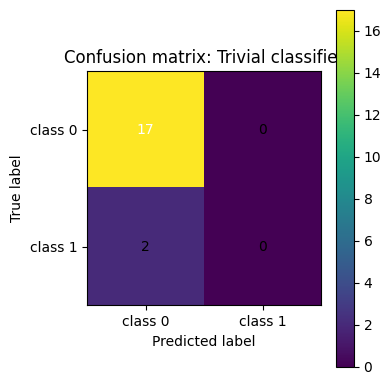

In [79]:
class TrivialClassifier:
    def fit(self, y_train):
        values, counts = np.unique(y_train, return_counts=True)
        self.majority_class_ = values[np.argmax(counts)]
        self.pos_proba_ = np.mean(y_train == 1)  # доля единиц в train
        return self
    
    def predict(self, X):
        return np.full(shape=(len(X),), fill_value=self.majority_class_, dtype=int)
    
    def predict_proba(self, X):
        n = len(X)
        proba_pos = np.full(n, self.pos_proba_)
        proba_neg = 1.0 - proba_pos
        return np.vstack([proba_neg, proba_pos]).T

triv_clf = TrivialClassifier().fit(y_train)
y_test_pred_triv = triv_clf.predict(X_test_std)
y_test_proba_triv = triv_clf.predict_proba(X_test_std)[:, 1]

metrics_triv = evaluate_model(y_test, y_test_pred_triv, y_test_proba_triv,
                              name="Trivial classifier")

plot_confusion_matrix(
    y_test, y_test_pred_triv,
    class_names=['class 0', 'class 1'],
    title='Confusion matrix: Trivial classifier'
)

=== Gaussian Naive Bayes ===
accuracy : 0.263
precision: 0.125
recall   : 1.000
f1       : 0.222
roc-auc  : 0.647
Confusion matrix [[TN, FP], [FN, TP]]:
[[ 3 14]
 [ 0  2]]



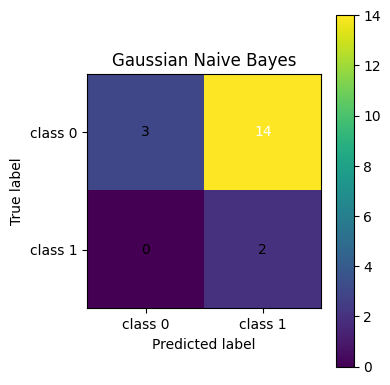

In [80]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        
        self.priors_ = np.zeros(n_classes)
        self.means_  = np.zeros((n_classes, n_features))
        self.vars_   = np.zeros((n_classes, n_features))
        
        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            self.priors_[idx] = len(X_c) / n_samples
            self.means_[idx, :] = X_c.mean(axis=0)
            self.vars_[idx,  :] = X_c.var(axis=0) + 1e-6  # небольшой эпсилон
    
        return self
    
    def _joint_log_likelihood(self, X):
        X = np.atleast_2d(X)
        n_samples, n_features = X.shape
        n_classes = len(self.classes_)
        log_lik = np.zeros((n_samples, n_classes))
        
        for idx in range(n_classes):
            mean = self.means_[idx]
            var  = self.vars_[idx]
            log_prior = np.log(self.priors_[idx])
            # лог-плотность нормального распределения по признакам
            term1 = -0.5 * np.sum(np.log(2.0 * np.pi * var))
            term2 = -0.5 * np.sum(((X - mean) ** 2) / var, axis=1)
            log_lik[:, idx] = log_prior + term1 + term2
        return log_lik
    
    def predict_proba(self, X):
        X = np.asarray(X)
        log_lik = self._joint_log_likelihood(X)
        # нормировка через лог-сумму-экспонент
        max_log = np.max(log_lik, axis=1, keepdims=True)
        exp_shifted = np.exp(log_lik - max_log)
        probs = exp_shifted / np.sum(exp_shifted, axis=1, keepdims=True)
        return probs
    
    def predict(self, X):
        probs = self.predict_proba(X)
        idx = np.argmax(probs, axis=1)
        return self.classes_[idx]

nb_clf = GaussianNaiveBayes().fit(X_train_std, y_train)
y_test_proba_nb = nb_clf.predict_proba(X_test_std)[:, 1]
y_test_pred_nb  = nb_clf.predict(X_test_std)

metrics_nb = evaluate_model(y_test, y_test_pred_nb, y_test_proba_nb,
                            name="Gaussian Naive Bayes")

plot_confusion_matrix(
    y_test, y_test_pred_nb,
    class_names=['class 0', 'class 1'],
    title='Gaussian Naive Bayes'
)

In [81]:
class KNNClassifier:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y):
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y)
        return self
    
    def _predict_one_proba(self, x):
        # Евклидовы расстояния до всех объектов из train
        diff = self.X_train - x
        distances = np.sqrt(np.sum(diff ** 2, axis=1))
        k = min(self.n_neighbors, len(self.X_train))
        nn_idx = np.argsort(distances)[:k]
        nn_labels = self.y_train[nn_idx]
        proba_pos = np.mean(nn_labels)  # доля единиц среди k соседей
        return proba_pos
    
    def predict_proba(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]
        proba_pos = np.zeros(n_samples)
        for i in range(n_samples):
            proba_pos[i] = self._predict_one_proba(X[i])
        proba_neg = 1.0 - proba_pos
        return np.vstack([proba_neg, proba_pos]).T
    
    def predict(self, X, threshold=0.5):
        proba_pos = self.predict_proba(X)[:, 1]
        return (proba_pos >= threshold).astype(int)

k_values = range(1, 25)
f1_scores = []
auc_scores = []

for k in k_values:
    knn = KNNClassifier(n_neighbors=k).fit(X_train_std, y_train)
    proba_val = knn.predict_proba(X_val_std)[:, 1]
    y_val_pred = (proba_val >= 0.5).astype(int)  # классификация по порогу 0.5
    _, _, f1 = precision_recall_f1(y_val, y_val_pred)
    auc = roc_auc_score_manual(y_val, proba_val)
    f1_scores.append(f1)
    auc_scores.append(auc)

for k, f1, auc in zip(k_values, f1_scores, auc_scores):
    print(f"k={k:2d}: F1={f1:.3f}, AUC={auc:.3f}")

best_k = k_values[int(np.argmax(auc_scores))]  # выбираем k с максимальным AUC
print("Оптимальное k по AUC на валидации:", best_k)

k= 1: F1=0.000, AUC=0.500
k= 2: F1=0.000, AUC=0.441
k= 3: F1=0.000, AUC=0.662
k= 4: F1=0.000, AUC=0.824
k= 5: F1=0.000, AUC=0.912
k= 6: F1=0.000, AUC=0.882
k= 7: F1=0.000, AUC=0.779
k= 8: F1=0.000, AUC=0.662
k= 9: F1=0.000, AUC=0.691
k=10: F1=0.000, AUC=0.662
k=11: F1=0.000, AUC=0.603
k=12: F1=0.000, AUC=0.559
k=13: F1=0.000, AUC=0.515
k=14: F1=0.000, AUC=0.515
k=15: F1=0.000, AUC=0.676
k=16: F1=0.000, AUC=0.676
k=17: F1=0.000, AUC=0.618
k=18: F1=0.000, AUC=0.529
k=19: F1=0.000, AUC=0.456
k=20: F1=0.000, AUC=0.426
k=21: F1=0.000, AUC=0.412
k=22: F1=0.000, AUC=0.382
k=23: F1=0.000, AUC=0.471
k=24: F1=0.000, AUC=0.515
Оптимальное k по AUC на валидации: 5


=== kNN (k=5) ===
accuracy : 0.895
precision: 0.000
recall   : 0.000
f1       : 0.000
roc-auc  : 0.485
Confusion matrix [[TN, FP], [FN, TP]]:
[[17  0]
 [ 2  0]]



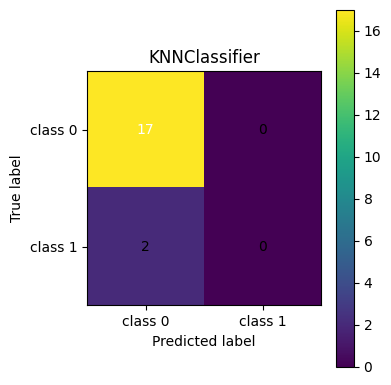

In [82]:
knn_best = KNNClassifier(n_neighbors=best_k).fit(X_train_std, y_train)
y_test_proba_knn = knn_best.predict_proba(X_test_std)[:, 1]
y_test_pred_knn  = (y_test_proba_knn >= 0.5).astype(int)

metrics_knn = evaluate_model(y_test, y_test_pred_knn, y_test_proba_knn,
                             name=f"kNN (k={best_k})")

plot_confusion_matrix(
    y_test, y_test_pred_knn,
    class_names=['class 0', 'class 1'],
    title='KNNClassifier'
)

In [83]:
class LogisticRegressionGD:
    def __init__(self, learning_rate=0.1, n_iter=5000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
    
    def _sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        n_samples, n_features = X.shape
        # добавляем столбец единиц для свободного члена
        Xb = np.hstack([np.ones((n_samples, 1)), X])
        self.w_ = np.zeros(Xb.shape[1])
        
        for _ in range(self.n_iter):
            z = Xb @ self.w_
            p = self._sigmoid(z)
            grad = (Xb.T @ (p - y)) / n_samples   # градиент логистической потери
            self.w_ -= self.learning_rate * grad
        return self
    
    def predict_proba(self, X):
        X = np.asarray(X)
        Xb = np.hstack([np.ones((X.shape[0], 1)), X])
        z = Xb @ self.w_
        p = self._sigmoid(z)
        return np.vstack([1 - p, p]).T
    
    def predict(self, X, threshold=0.5):
        proba_pos = self.predict_proba(X)[:, 1]
        return (proba_pos >= threshold).astype(int)

log_reg = LogisticRegressionGD(learning_rate=0.1, n_iter=5000).fit(X_train_std, y_train)

# вероятности на валидационной выборке
y_val_proba_lr = log_reg.predict_proba(X_val_std)[:, 1]


Лучший порог по F1 на валидации: 0.01, F1 = 0.235


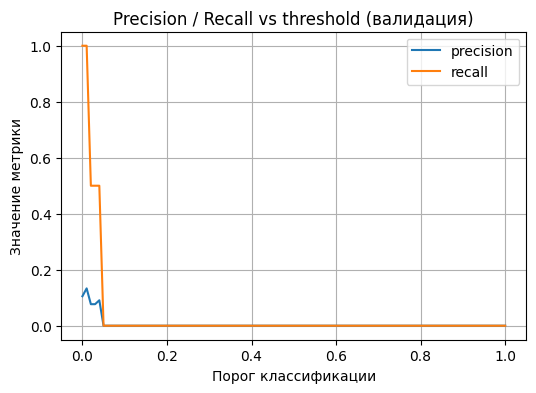

In [84]:
def precision_recall_curve_and_best_f1(y_true, y_scores, n_thresholds=101):
    thresholds = np.linspace(0.0, 1.0, n_thresholds)
    precisions, recalls, f1s = [], [], []
    for t in thresholds:
        y_pred = (y_scores >= t).astype(int)
        p, r, f1 = precision_recall_f1(y_true, y_pred)
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)
    precisions = np.array(precisions)
    recalls   = np.array(recalls)
    f1s       = np.array(f1s)
    best_idx = int(np.argmax(f1s))
    best_thr = thresholds[best_idx]
    return thresholds, precisions, recalls, f1s, best_thr, f1s[best_idx]

thresholds, precisions, recalls, f1s, best_thr, best_f1 = \
    precision_recall_curve_and_best_f1(y_val, y_val_proba_lr)

print(f"Лучший порог по F1 на валидации: {best_thr:.2f}, F1 = {best_f1:.3f}")

plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions, label="precision")
plt.plot(thresholds, recalls,   label="recall")
plt.xlabel("Порог классификации")
plt.ylabel("Значение метрики")
plt.title("Precision / Recall vs threshold (валидация)")
plt.grid(True)
plt.legend()
plt.show()

=== Logistic regression (thr=0.01) ===
accuracy : 0.368
precision: 0.143
recall   : 1.000
f1       : 0.250
roc-auc  : 0.618
Confusion matrix [[TN, FP], [FN, TP]]:
[[ 5 12]
 [ 0  2]]



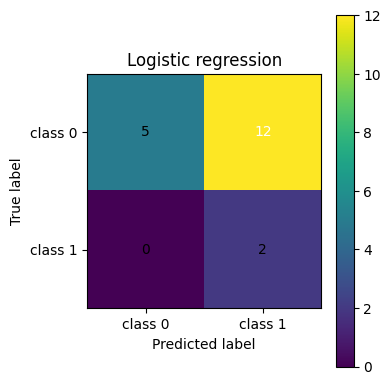

In [85]:
y_test_proba_lr = log_reg.predict_proba(X_test_std)[:, 1]
y_test_pred_lr  = (y_test_proba_lr >= best_thr).astype(int)

metrics_lr = evaluate_model(y_test, y_test_pred_lr, y_test_proba_lr,
                            name=f"Logistic regression (thr={best_thr:.2f})")

plot_confusion_matrix(
    y_test, y_test_pred_lr,
    class_names=['class 0', 'class 1'],
    title='Logistic regression'
)

In [86]:
summary = pd.DataFrame([
    {"model": "Trivial",
     **{k: v for k, v in metrics_triv.items() if k != "cm"}},
    {"model": "Naive Bayes",
     **{k: v for k, v in metrics_nb.items()   if k != "cm"}},
    {"model": f"kNN (k={best_k})",
     **{k: v for k, v in metrics_knn.items() if k != "cm"}},
    {"model": f"LogReg (thr={best_thr:.2f})",
     **{k: v for k, v in metrics_lr.items()  if k != "cm"}},
])

summary

,model,accuracy,precision,recall,f1,roc_auc
0,Trivial,0.894737,0.000000,0.0,0.000000,0.500000
1,Naive Bayes,0.263158,0.125000,1.0,0.222222,0.647059
2,kNN (k=5),0.894737,0.000000,0.0,0.000000,0.485294
3,LogReg (thr=0.01),0.368421,0.142857,1.0,0.250000,0.617647
